<a href="https://colab.research.google.com/github/Erika1235/xrayanalysis/blob/erika/Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:177: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


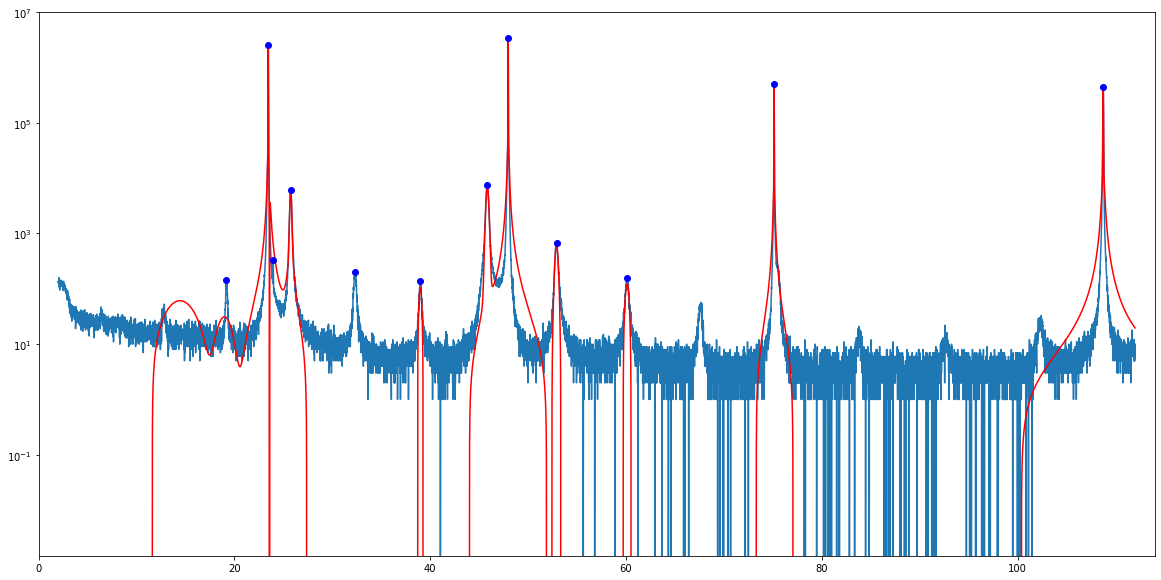

In [23]:
import matplotlib.pyplot as plt
import numpy as np
# BeautifulSoup XML Parser
# API: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
from bs4 import BeautifulSoup


import matplotlib
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy import signal
from matplotlib.figure import Figure
from matplotlib.widgets import Cursor
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from scipy.special import wofz
from scipy.integrate import quad
from scipy.interpolate import interp1d
from matplotlib.pyplot import figure

from google.colab import drive
drive.mount('/content/drive')
infile = '/content/drive/My Drive/Colab Notebooks/Test/JAMPM149_Nd4Ni3O10_LAO(100)_tth_full_b (1).xrdml'

# converts xrdml file into BeautifulSoup object
def convertToBS(filename):
  with open(filename,'r') as file:
    file_input = file.read()
  return BeautifulSoup(file_input)

# get 2Theta start and end positions
def get2Theta(filename):
  soup = convertToBS(filename)
  return [float(soup.startposition.string),float(soup.endposition.string)]

# get intensities of tth scan 
def getIntensities(filename):
  soup = convertToBS(filename)
  return [float(intensity) for intensity in soup.intensities.string.split()]

# get id 
def getID(filename):
  soup = convertToBS(filename)
  return soup.id.string

# create dictionary of 2Theta and intensity values
def createDict(filename):
  d = {}
  [tth_beg,tth_end] = get2Theta(filename)
  intensities = getIntensities(filename)
  tth = tth_beg
  incr = (tth_end - tth_beg) / (len(intensities) - 1)
  for i in intensities:
    d[tth] = i
    tth = tth + incr
  return d


#TODO: Data Analysis
# Resolve Peaks (Maxima)
# Gaussian smoothing function
def gaussianSmooth(x,y,sigma,std):
  smoothed_vals = np.zeros(y.shape)
  fwhm = sigma * np.sqrt(8 * np.log(2))
  incr = x[1] - x[0]
  ind_incr = int(round(std*fwhm/incr))
  x = np.pad(x,ind_incr)
  y = np.pad(y,ind_incr)

  for i in range(len(x)-2*ind_incr):
    kernel = np.exp(-(x[i:i+2*ind_incr] - x[i+ind_incr]) ** 2 / (2 * sigma ** 2))
    kernel = kernel/ sum(kernel)
    smoothed_vals[i] = sum(y[i:i+2*ind_incr] * kernel)
  return smoothed_vals

def fourierSeries(x,y,r):
  L = (x[-1] - x[0])
  dx = x[1] - x[0]
  A0 = np.sum(y * np.ones_like(x)) * dx
  fFs = A0/2
  A = np.zeros(r)
  B = np.zeros(r)
  for i in range(r):
    A[i] = np.sum(y * np.cos(np.pi*(i+1)*x/L)) * dx
    B[i] = np.sum(y * np.sin(np.pi*(i+1)*x/L)) * dx
    fFs = fFs + A[i]*np.cos(np.pi*(i+1)*x/L) + B[i]*np.sin(np.pi*(i+1)*x/L)
  plt.semilogy(x,fFs)


#TODO: Data Output
def plotSemilogy(x,y):
  plt.semilogy(x,y)
  plt.semilogy(x,gaussianSmooth(x_vals,y_vals,0.3,2))
  plt.xlabel(r'Angle (2$\Theta$)')
  plt.ylabel(r'Intensity (Arb. Units)')
  
  

tth = createDict(infile)
x_vals,y_vals = np.array(list(tth.keys())),np.array(list(tth.values()))

def merge(list1, list2): 
  merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))] 
  return merged_list 

#This plots all of the peaks and all of the valleys 
def plotPeakAndValley(x,y):
  # Find peaks(max).
  peak_indexes = signal.argrelextrema(y_vals, np.greater)
  peak_indexes = peak_indexes[0]

  # Find valleys(min).
  valley_indexes = signal.argrelextrema(y_vals, np.less)
  valley_indexes = valley_indexes[0]

  #Plot main graph 
  (fig, ax) = plt.subplots()
  ax.plot(x,y)

  #Plot peaks
  peak_x = x_vals[peak_indexes]
  peak_y = y_vals[peak_indexes]
  plt.semilogy()
  ax.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='green', label="Peaks")
  
  #Plot Valleys 
  valley_x = x_vals[valley_indexes]
  valley_y = y_vals[valley_indexes]
  plt.semilogy()
  ax.plot(valley_x, valley_y, marker='o', linestyle='dashed', color='red', label="Valleys")

#plotPeakAndValley(x_vals,y_vals)


peaks, _ = find_peaks(y_vals, prominence = 95)

def prominentPeaks(x,y):
  plt.plot(x[peaks], y[peaks], "ob")
  #plt.plot(y)
  #plt.legend(['prominence']); #plt.semilogy(x,y)

def getwidth(sigma):
  fwhm = sigma * np.sqrt(8 * np.log(2))
  return (fwhm)

temp = []
for index in peaks:
  temp.append(y_vals[index])
  temp.append(x_vals[index])
  temp.append(0.03)
  temp.append(getwidth(0.01))

#Not the best fit; will continue working on it 
def Voigt(x, *params):
  y = np.zeros_like(x)
  for i in range (0, len(params), 4):
    ampG1 = params[i]
    cenG1 = params[i+1]
    sigmaG1 = abs(params[i+2])
    ampL1 = params[i]
    cenL1 = params[i+1]
    widL1 = abs(params[i+3])          
    #Gauss: (ampG1*(1/(sigmaG1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cenG1)**2)/((2*sigmaG1)**2))))
    #Lorentzian: ((ampL1*widL1**2/((x-cenL1)**2+widL1**2)))
    #Need to set weights 
    y = y + ((ampG1*(1/(sigmaG1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cenG1)**2)/((2*sigmaG1)**2)))) + ((ampL1*widL1**2/((x-cenL1)**2+widL1**2))))
  return y
popt, pcov = curve_fit(Voigt, x_vals, y_vals, p0 = temp, maxfev = 1000000)
fit = Voigt(x_vals, *popt)

plt.figure(figsize=(20,10))
plt.semilogy(x_vals, y_vals)
plt.semilogy(x_vals, fit , 'r-')
plt.plot(x_vals[peaks], y_vals[peaks], "ob")
plt.xlim([0,114])
plt.ylim([0,1e7])
plt.show()
